## 1. Import Required Libraries and Setup

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now()}")

Libraries imported successfully!
Analysis started at: 2025-11-19 22:59:52.320878


## 2. Data Loading and Initial Exploration

In [13]:
# Load datasets
print("Loading dataset")

# Load Fear & Greed Index data
sentiment_df = pd.read_csv('csv_files/fear_greed_index.csv')
print(f"Sentiment data shape: {sentiment_df.shape}")
print("\nSentiment data columns:", sentiment_df.columns.tolist())
print("\nSentiment data sample:")
print(sentiment_df.head())

print("\n" + "="*50)

# Load trading data
trading_df = pd.read_csv('csv_files/historical_data.csv')
print(f"Trading data shape: {trading_df.shape}")
print("\nTrading data columns:", trading_df.columns.tolist())
print("\nTrading data sample:")
print(trading_df.head())

Loading dataset
Sentiment data shape: (2644, 4)

Sentiment data columns: ['timestamp', 'value', 'classification', 'date']

Sentiment data sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trading data shape: (211224, 16)

Trading data columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Trading data sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         

## 3. Data Cleaning and Preprocessing

In [3]:
# Clean and preprocess sentiment data
print("Preprocessing sentiment data...")

# Convert date column
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')

# Check for missing values
print("Missing values in sentiment data:")
print(sentiment_df.isnull().sum())

# Display unique classifications
print("\nUnique sentiment classifications:")
print(sentiment_df['classification'].value_counts())

print("\n" + "="*50)
print("Preprocessing trading data...")

# Clean trading data
# Convert timestamp column
trading_df['date'] = pd.to_datetime(trading_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trading_df['Timestamp'] = pd.to_datetime(trading_df['Timestamp'], unit='s', errors='coerce')

# Clean numeric columns
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Fee']
for col in numeric_cols:
    trading_df[col] = pd.to_numeric(trading_df[col], errors='coerce')

# Check missing values
print("Missing values in trading data:")
print(trading_df.isnull().sum())

# Basic statistics
print("\nTrading data date range:")
print(f"From: {trading_df['date'].min()} To: {trading_df['date'].max()}")

print("\nUnique traders:", trading_df['Account'].nunique())
print("Total trades:", len(trading_df))

Preprocessing sentiment data...
Missing values in sentiment data:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Unique sentiment classifications:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Preprocessing trading data...
Missing values in trading data:
Account                  0
Coin                     0
Execution Price          0
Size Tokens              0
Size USD                 0
Side                     0
Timestamp IST            0
Start Position           0
Direction                0
Closed PnL               0
Transaction Hash         0
Order ID                 0
Crossed                  0
Fee                      0
Trade ID                 0
Timestamp           211224
date                     0
dtype: int64

Trading data date range:
From: 2023-05-01 01:06:00 To: 2025-05-01 12:13:00

Unique traders: 32
Total trades: 211224


## 4. Exploratory Data Analysis (EDA)

=== SENTIMENT ANALYSIS ===


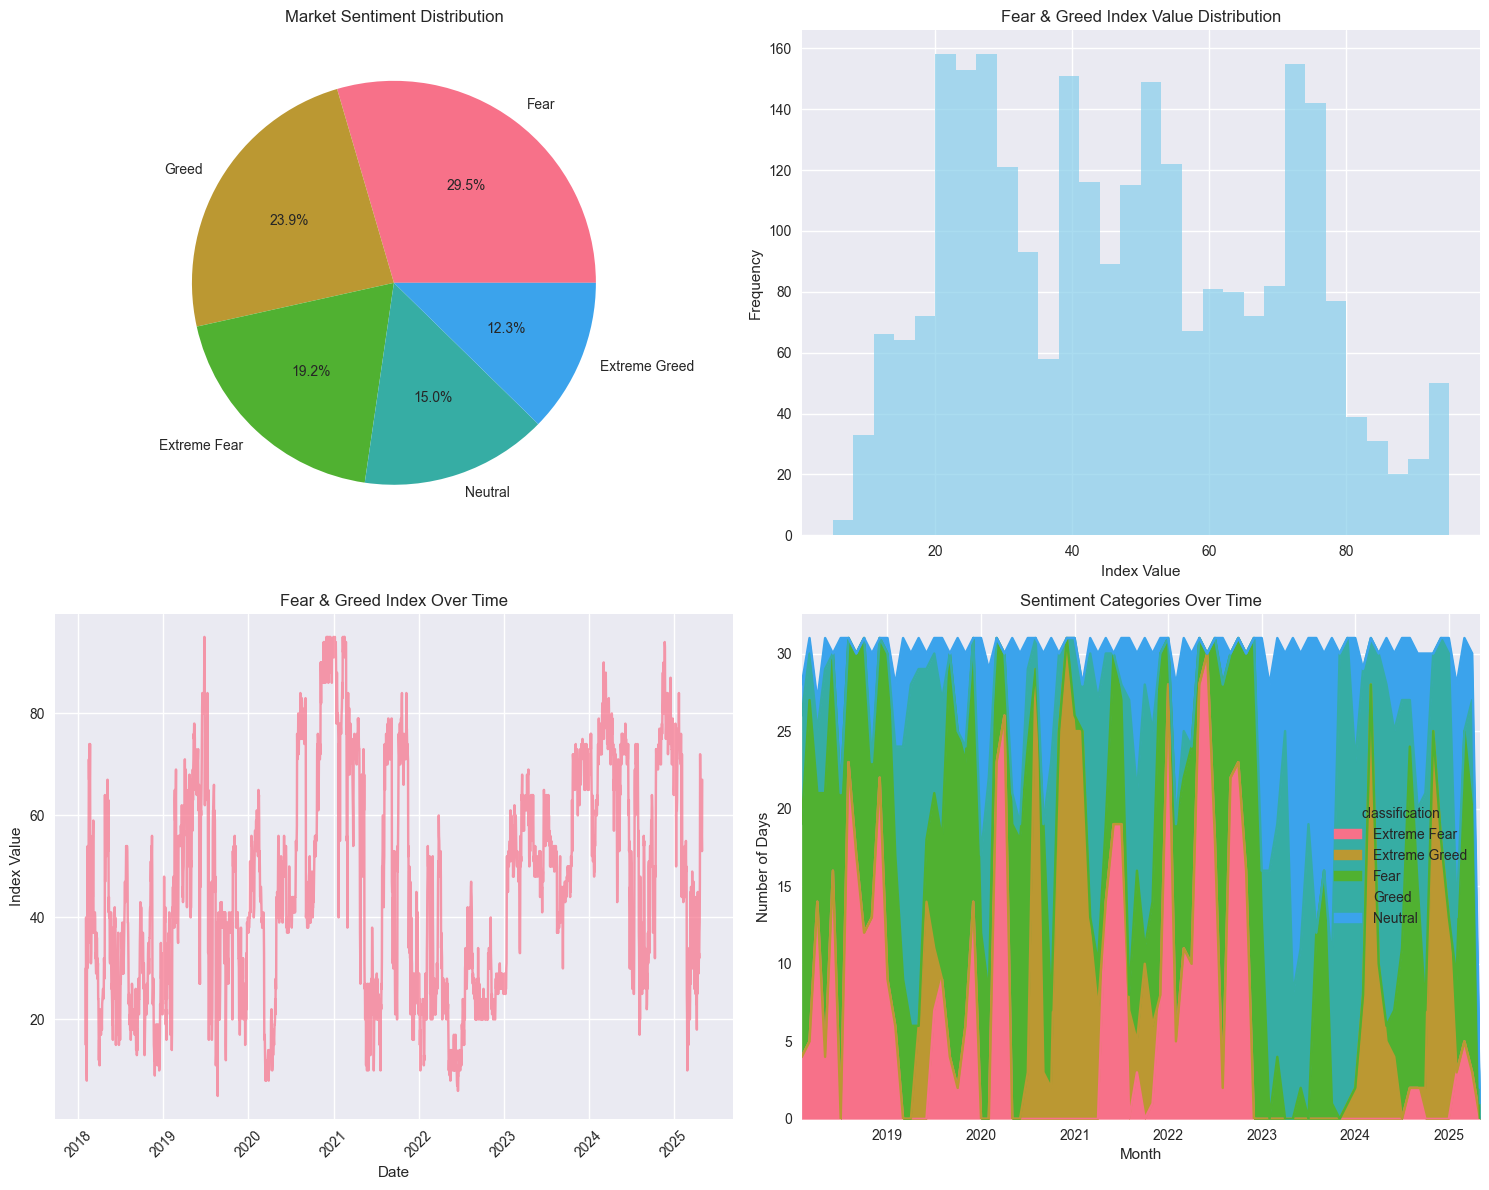


Sentiment Value Statistics:
count    2644.000000
mean       46.981089
std        21.827680
min         5.000000
25%        28.000000
50%        46.000000
75%        66.000000
max        95.000000
Name: value, dtype: float64


In [4]:
# Sentiment Distribution Analysis
print("=== SENTIMENT ANALYSIS ===")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Sentiment distribution
sentiment_counts = sentiment_df['classification'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Market Sentiment Distribution')

# Plot 2: Sentiment value distribution
axes[0, 1].hist(sentiment_df['value'], bins=30, alpha=0.7, color='skyblue')
axes[0, 1].set_title('Fear & Greed Index Value Distribution')
axes[0, 1].set_xlabel('Index Value')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Time series of sentiment
sentiment_df_sorted = sentiment_df.sort_values('date')
axes[1, 0].plot(sentiment_df_sorted['date'], sentiment_df_sorted['value'], alpha=0.7)
axes[1, 0].set_title('Fear & Greed Index Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Index Value')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Sentiment categories over time
sentiment_monthly = sentiment_df.groupby([sentiment_df['date'].dt.to_period('M'), 'classification']).size().unstack(fill_value=0)
sentiment_monthly.plot(kind='area', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Sentiment Categories Over Time')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Days')

plt.tight_layout()
plt.savefig('outputs/sentiment_eda.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSentiment Value Statistics:")
print(sentiment_df['value'].describe())

=== TRADING DATA ANALYSIS ===


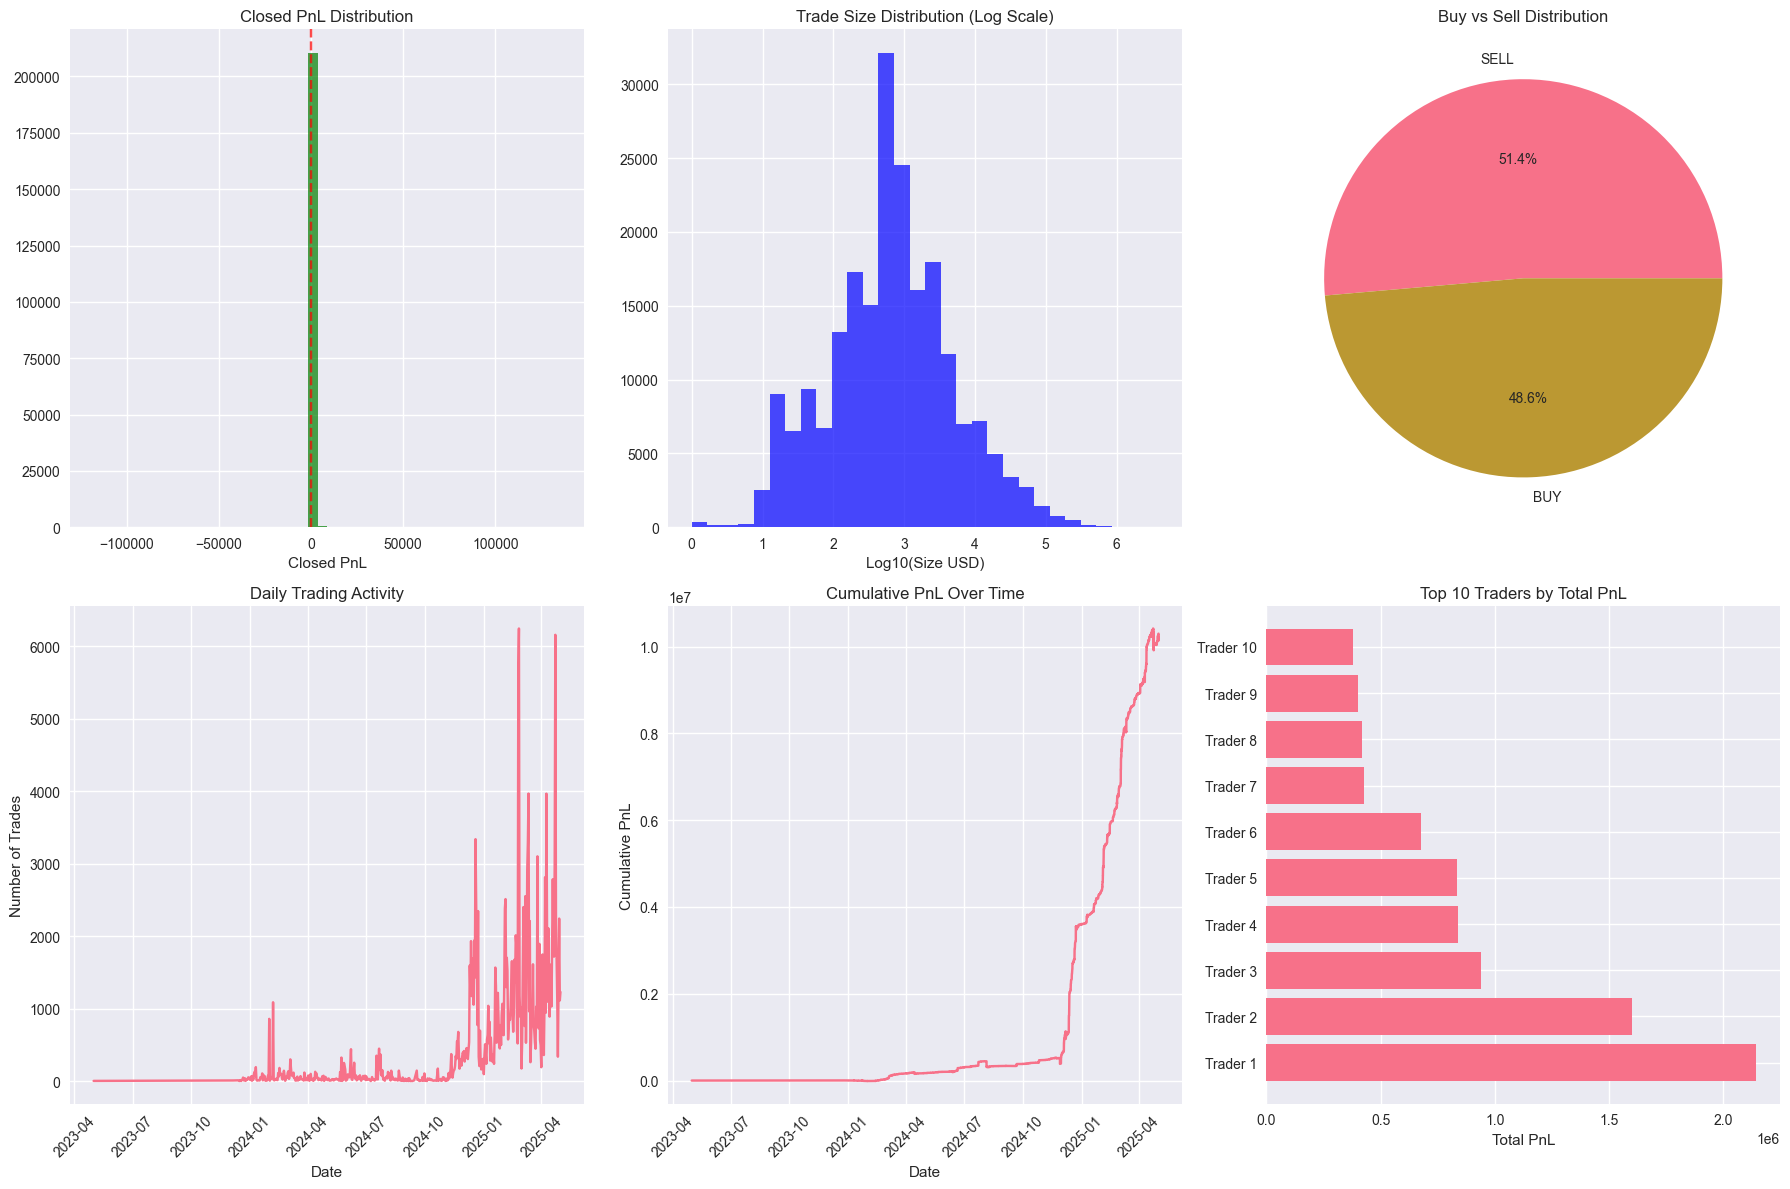


Trading Summary Statistics:
Total trades: 211224
Unique traders: 32
Total PnL: $10,296,958.94
Win rate: 41.13%


In [5]:
# Trading Data Analysis
print("=== TRADING DATA ANALYSIS ===")

# Remove rows with missing critical data
trading_clean = trading_df.dropna(subset=['date', 'Closed PnL', 'Size USD'])

# Create comprehensive trading analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: PnL distribution
pnl_data = trading_clean['Closed PnL'].replace([np.inf, -np.inf], np.nan).dropna()
axes[0, 0].hist(pnl_data, bins=50, alpha=0.7, color='green')
axes[0, 0].set_title('Closed PnL Distribution')
axes[0, 0].set_xlabel('Closed PnL')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Plot 2: Trade size distribution
size_data = trading_clean['Size USD'].replace([np.inf, -np.inf], np.nan).dropna()
axes[0, 1].hist(np.log10(size_data + 1), bins=30, alpha=0.7, color='blue')
axes[0, 1].set_title('Trade Size Distribution (Log Scale)')
axes[0, 1].set_xlabel('Log10(Size USD)')

# Plot 3: Buy vs Sell distribution
side_counts = trading_clean['Side'].value_counts()
axes[0, 2].pie(side_counts.values, labels=side_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Buy vs Sell Distribution')

# Plot 4: Trading activity over time
daily_trades = trading_clean.groupby(trading_clean['date'].dt.date).size()
axes[1, 0].plot(daily_trades.index, daily_trades.values)
axes[1, 0].set_title('Daily Trading Activity')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Trades')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Cumulative PnL over time
trading_sorted = trading_clean.sort_values('date')
trading_sorted['cumulative_pnl'] = trading_sorted['Closed PnL'].cumsum()
axes[1, 1].plot(trading_sorted['date'], trading_sorted['cumulative_pnl'])
axes[1, 1].set_title('Cumulative PnL Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative PnL')
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot 6: Top traders by total PnL
trader_pnl = trading_clean.groupby('Account')['Closed PnL'].sum().nlargest(10)
axes[1, 2].barh(range(len(trader_pnl)), trader_pnl.values)
axes[1, 2].set_yticks(range(len(trader_pnl)))
axes[1, 2].set_yticklabels([f"Trader {i+1}" for i in range(len(trader_pnl))])
axes[1, 2].set_title('Top 10 Traders by Total PnL')
axes[1, 2].set_xlabel('Total PnL')

plt.tight_layout()
plt.savefig('outputs/trading_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTrading Summary Statistics:")
print(f"Total trades: {len(trading_clean)}")
print(f"Unique traders: {trading_clean['Account'].nunique()}")
print(f"Total PnL: ${trading_clean['Closed PnL'].sum():,.2f}")
print(f"Win rate: {(trading_clean['Closed PnL'] > 0).mean()*100:.2f}%")

## 5. Trader Performance Metrics Calculation

In [6]:
# Calculate comprehensive trader performance metrics
print("Calculating trader performance metrics...")

def calculate_trader_metrics(df):
    """Calculate comprehensive performance metrics for each trader"""
    metrics = {}
    
    # Group by trader
    trader_groups = df.groupby('Account')
    
    trader_metrics = []
    
    for trader, group in trader_groups:
        # Basic metrics
        total_trades = len(group)
        total_pnl = group['Closed PnL'].sum()
        total_volume = group['Size USD'].sum()
        
        # Performance metrics
        winning_trades = (group['Closed PnL'] > 0).sum()
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        avg_trade_size = group['Size USD'].mean()
        avg_pnl_per_trade = group['Closed PnL'].mean()
        
        # Risk metrics
        pnl_std = group['Closed PnL'].std() if len(group) > 1 else 0
        sharpe_ratio = avg_pnl_per_trade / pnl_std if pnl_std != 0 else 0
        
        max_drawdown = 0
        if len(group) > 1:
            cumulative_pnl = group.sort_values('date')['Closed PnL'].cumsum()
            running_max = cumulative_pnl.expanding().max()
            drawdown = (cumulative_pnl - running_max)
            max_drawdown = drawdown.min()
        
        # Trading frequency
        date_range = (group['date'].max() - group['date'].min()).days
        trades_per_day = total_trades / max(date_range, 1)
        
        # Portfolio concentration
        unique_coins = group['Coin'].nunique()
        
        trader_metrics.append({
            'trader_id': trader,
            'total_trades': total_trades,
            'total_pnl': total_pnl,
            'total_volume': total_volume,
            'win_rate': win_rate,
            'avg_trade_size': avg_trade_size,
            'avg_pnl_per_trade': avg_pnl_per_trade,
            'pnl_volatility': pnl_std,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'trades_per_day': trades_per_day,
            'unique_coins': unique_coins,
            'first_trade_date': group['date'].min(),
            'last_trade_date': group['date'].max()
        })
    
    return pd.DataFrame(trader_metrics)

# Calculate metrics
trader_metrics = calculate_trader_metrics(trading_clean)

# Display top performers
print("\n=== TOP PERFORMING TRADERS ===")
print("\nTop 10 traders by total PnL:")
top_pnl = trader_metrics.nlargest(10, 'total_pnl')[['trader_id', 'total_pnl', 'win_rate', 'total_trades', 'sharpe_ratio']]
print(top_pnl)

print("\nTop 10 traders by Sharpe ratio (min 10 trades):")
top_sharpe = trader_metrics[trader_metrics['total_trades'] >= 10].nlargest(10, 'sharpe_ratio')
top_sharpe_display = top_sharpe[['trader_id', 'sharpe_ratio', 'total_pnl', 'win_rate', 'total_trades']]
print(top_sharpe_display)

print(f"\nTotal traders analyzed: {len(trader_metrics)}")
print(f"Traders with profitable trading: {(trader_metrics['total_pnl'] > 0).sum()}")
print(f"Average win rate: {trader_metrics['win_rate'].mean():.2%}")

Calculating trader performance metrics...

=== TOP PERFORMING TRADERS ===

Top 10 traders by total PnL:
                                     trader_id     total_pnl  win_rate  \
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06  0.337134   
0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  0.359612   
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05  0.467582   
13  0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05  0.401193   
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05  0.428230   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05  0.486226   
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05  0.345912   
9   0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05  0.484236   
16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  4.030115e+05  0.306294   
17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.790954e+05  0.810876   

    total_trades  sharpe_ratio  
27         14733      0.105880  
0           381

## 6. Data Merging and Sentiment-Performance Analysis

In [7]:
# Prepare data for sentiment-performance analysis
print("Preparing sentiment-performance analysis...")

# Create daily trading aggregations
trading_clean['trade_date'] = trading_clean['date'].dt.date
daily_trading_metrics = trading_clean.groupby('trade_date').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': ['sum', 'mean'],
    'Account': 'nunique'
}).reset_index()

# Flatten column names
daily_trading_metrics.columns = ['date', 'total_pnl', 'avg_pnl', 'total_trades', 
                                 'total_volume', 'avg_trade_size', 'unique_traders']

# Calculate additional daily metrics
daily_win_rates = trading_clean.groupby('trade_date').apply(
    lambda x: (x['Closed PnL'] > 0).mean()
).reset_index()
daily_win_rates.columns = ['date', 'daily_win_rate']

# Merge trading metrics
daily_trading_metrics = daily_trading_metrics.merge(daily_win_rates, on='date')

# Prepare sentiment data for merging
sentiment_clean = sentiment_df.copy()
sentiment_clean['date'] = sentiment_clean['date'].dt.date
sentiment_clean = sentiment_clean[['date', 'value', 'classification']].drop_duplicates()

# Merge datasets
combined_data = daily_trading_metrics.merge(sentiment_clean, on='date', how='inner')

print(f"Successfully merged data for {len(combined_data)} days")
print(f"Date range: {combined_data['date'].min()} to {combined_data['date'].max()}")

# Display sample of merged data
print("\nSample of merged data:")
print(combined_data.head())

# Create sentiment categories for analysis
def categorize_sentiment(value):
    if value >= 75:
        return 'Extreme Greed'
    elif value >= 55:
        return 'Greed'
    elif value >= 45:
        return 'Neutral'
    elif value >= 25:
        return 'Fear'
    else:
        return 'Extreme Fear'

combined_data['sentiment_category'] = combined_data['value'].apply(categorize_sentiment)

print("\nSentiment category distribution in merged data:")
print(combined_data['sentiment_category'].value_counts())

Preparing sentiment-performance analysis...
Successfully merged data for 479 days
Date range: 2023-05-01 to 2025-05-01

Sample of merged data:
         date   total_pnl    avg_pnl  total_trades  total_volume  \
0  2023-05-01    0.000000   0.000000             3        477.00   
1  2023-12-05    0.000000   0.000000             9      50005.83   
2  2023-12-14 -205.434737 -18.675885            11     113203.35   
3  2023-12-15  -24.632034 -12.316017             2      10609.95   
4  2023-12-16    0.000000   0.000000             3      15348.77   

   avg_trade_size  unique_traders  daily_win_rate  value classification  
0      159.000000               1        0.000000     63          Greed  
1     5556.203333               1        0.000000     75  Extreme Greed  
2    10291.213636               1        0.363636     72          Greed  
3     5304.975000               1        0.000000     70          Greed  
4     5116.256667               1        0.000000     67          Greed  

Sen

## 7. Correlation Analysis: Sentiment vs Trading Performance

=== SENTIMENT vs TRADING PERFORMANCE CORRELATION ANALYSIS ===


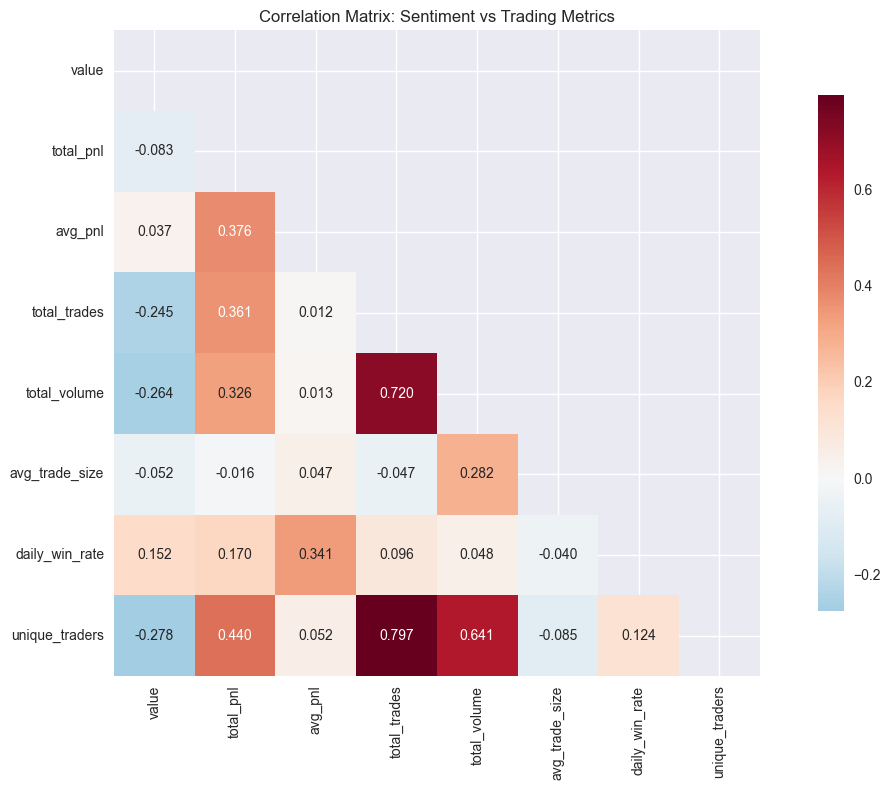


=== STATISTICAL SIGNIFICANCE TESTS ===

TOTAL_PNL:
  Correlation with Fear/Greed Index: -0.0826
  P-value: 0.0708
  Significant: No

AVG_PNL:
  Correlation with Fear/Greed Index: 0.0373
  P-value: 0.4152
  Significant: No

DAILY_WIN_RATE:
  Correlation with Fear/Greed Index: 0.1525
  P-value: 0.0008
  Significant: Yes

TOTAL_VOLUME:
  Correlation with Fear/Greed Index: -0.2644
  P-value: 0.0000
  Significant: Yes

AVG_TRADE_SIZE:
  Correlation with Fear/Greed Index: -0.0518
  P-value: 0.2576
  Significant: No

=== PERFORMANCE BY SENTIMENT CATEGORIES ===
                     total_pnl                            daily_win_rate  \
                          mean          std           sum           mean   
sentiment_category                                                         
Extreme Fear        52793.5892  101262.3941  7.391102e+05         0.3273   
Extreme Greed       23817.2922   72827.3016  2.715171e+06         0.4674   
Fear                36891.8180   96611.8485  3.357155e+06  

In [8]:
# Comprehensive correlation analysis
print("=== SENTIMENT vs TRADING PERFORMANCE CORRELATION ANALYSIS ===")

# Calculate correlation matrix
correlation_vars = ['value', 'total_pnl', 'avg_pnl', 'total_trades', 
                   'total_volume', 'avg_trade_size', 'daily_win_rate', 'unique_traders']

correlation_matrix = combined_data[correlation_vars].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Sentiment vs Trading Metrics')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance tests
print("\n=== STATISTICAL SIGNIFICANCE TESTS ===")

metrics_to_test = ['total_pnl', 'avg_pnl', 'daily_win_rate', 'total_volume', 'avg_trade_size']

for metric in metrics_to_test:
    # Correlation with sentiment value
    corr_coef, p_value = stats.pearsonr(combined_data['value'], combined_data[metric])
    print(f"\n{metric.upper()}:")
    print(f"  Correlation with Fear/Greed Index: {corr_coef:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Group analysis by sentiment categories
print("\n=== PERFORMANCE BY SENTIMENT CATEGORIES ===")

sentiment_performance = combined_data.groupby('sentiment_category').agg({
    'total_pnl': ['mean', 'std', 'sum'],
    'daily_win_rate': ['mean', 'std'],
    'total_volume': ['mean', 'std'],
    'avg_trade_size': ['mean', 'std'],
    'total_trades': ['mean', 'std'],
    'value': 'count'
}).round(4)

print(sentiment_performance)

## 8. Advanced Visualization: Sentiment vs Performance Patterns

In [9]:
# Create comprehensive visualization dashboard
print("Creating advanced visualizations...")

# Create a large figure with multiple subplots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Fear/Greed Index vs Daily PnL',
        'Sentiment vs Win Rate',
        'Trading Volume by Sentiment',
        'Trade Count by Sentiment',
        'Sentiment vs Average Trade Size',
        'Cumulative Performance by Sentiment'
    ),
    specs=[[{"secondary_y": True}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Sort data by date for time series
combined_sorted = combined_data.sort_values('date')

# Plot 1: Fear/Greed Index vs Daily PnL
fig.add_trace(
    go.Scatter(
        x=combined_sorted['date'],
        y=combined_sorted['value'],
        name='Fear/Greed Index',
        line=dict(color='blue')
    ),
    row=1, col=1, secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=combined_sorted['date'],
        y=combined_sorted['total_pnl'],
        name='Daily PnL',
        line=dict(color='red'),
        yaxis='y2'
    ),
    row=1, col=1, secondary_y=True
)

# Plot 2: Sentiment vs Win Rate
fig.add_trace(
    go.Scatter(
        x=combined_data['value'],
        y=combined_data['daily_win_rate'],
        mode='markers',
        name='Win Rate vs Sentiment',
        marker=dict(color='green', opacity=0.6)
    ),
    row=1, col=2
)

# Plot 3: Trading Volume by Sentiment
sentiment_volume = combined_data.groupby('sentiment_category')['total_volume'].mean().reset_index()
fig.add_trace(
    go.Bar(
        x=sentiment_volume['sentiment_category'],
        y=sentiment_volume['total_volume'],
        name='Avg Volume by Sentiment',
        marker_color='purple'
    ),
    row=2, col=1
)

# Plot 4: Trade Count by Sentiment
sentiment_trades = combined_data.groupby('sentiment_category')['total_trades'].mean().reset_index()
fig.add_trace(
    go.Bar(
        x=sentiment_trades['sentiment_category'],
        y=sentiment_trades['total_trades'],
        name='Avg Trades by Sentiment',
        marker_color='orange'
    ),
    row=2, col=2
)

# Plot 5: Sentiment vs Average Trade Size
fig.add_trace(
    go.Scatter(
        x=combined_data['value'],
        y=combined_data['avg_trade_size'],
        mode='markers',
        name='Trade Size vs Sentiment',
        marker=dict(color='brown', opacity=0.6)
    ),
    row=3, col=1
)

# Plot 6: Cumulative Performance by Sentiment Category
cumulative_by_sentiment = combined_data.groupby('sentiment_category')['total_pnl'].sum().reset_index()
fig.add_trace(
    go.Bar(
        x=cumulative_by_sentiment['sentiment_category'],
        y=cumulative_by_sentiment['total_pnl'],
        name='Total PnL by Sentiment',
        marker_color='teal'
    ),
    row=3, col=2
)

# Update layout
fig.update_layout(
    height=1200,
    title_text="Comprehensive Sentiment vs Trading Performance Analysis",
    showlegend=False
)

# Save and show
fig.write_html('outputs/sentiment_performance_dashboard.html')
fig.show()

print("Interactive dashboard saved to outputs/sentiment_performance_dashboard.html")

Creating advanced visualizations...


Interactive dashboard saved to outputs/sentiment_performance_dashboard.html


## 9. Hidden Pattern Discovery: Advanced Analytics

In [10]:
# Advanced pattern discovery
print("=== ADVANCED PATTERN DISCOVERY ===")

# 1. Sentiment Transition Analysis
print("\n1. SENTIMENT TRANSITION ANALYSIS")
combined_sorted = combined_data.sort_values('date')
combined_sorted['sentiment_shift'] = combined_sorted['value'].diff()
combined_sorted['sentiment_direction'] = combined_sorted['sentiment_shift'].apply(
    lambda x: 'Improving' if x > 5 else ('Deteriorating' if x < -5 else 'Stable')
)

transition_performance = combined_sorted.groupby('sentiment_direction').agg({
    'total_pnl': ['mean', 'std'],
    'daily_win_rate': ['mean', 'std'],
    'total_volume': 'mean'
}).round(4)

print("Performance during different sentiment transitions:")
print(transition_performance)

# 2. Extreme Sentiment Analysis
print("\n2. EXTREME SENTIMENT ANALYSIS")
extreme_fear = combined_data[combined_data['value'] <= 20]
extreme_greed = combined_data[combined_data['value'] >= 80]

print(f"\nExtreme Fear periods ({len(extreme_fear)} days):")
print(f"  Average daily PnL: ${extreme_fear['total_pnl'].mean():,.2f}")
print(f"  Average win rate: {extreme_fear['daily_win_rate'].mean():.2%}")
print(f"  Average volume: ${extreme_fear['total_volume'].mean():,.2f}")

print(f"\nExtreme Greed periods ({len(extreme_greed)} days):")
print(f"  Average daily PnL: ${extreme_greed['total_pnl'].mean():,.2f}")
print(f"  Average win rate: {extreme_greed['daily_win_rate'].mean():.2%}")
print(f"  Average volume: ${extreme_greed['total_volume'].mean():,.2f}")

# 3. Trader Behavior Clustering
print("\n3. TRADER BEHAVIOR CLUSTERING")

# Prepare data for clustering
clustering_features = ['total_trades', 'total_pnl', 'win_rate', 'avg_trade_size', 'sharpe_ratio']
clustering_data = trader_metrics[clustering_features].fillna(0)

# Replace infinite values
clustering_data = clustering_data.replace([np.inf, -np.inf], 0)

# Standardize features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
trader_clusters = kmeans.fit_predict(clustering_data_scaled)
trader_metrics['cluster'] = trader_clusters

# Analyze clusters
cluster_analysis = trader_metrics.groupby('cluster')[clustering_features].mean().round(4)
print("\nTrader Clusters Analysis:")
print(cluster_analysis)

# 4. Sentiment Timing Analysis
print("\n4. SENTIMENT TIMING ANALYSIS")

# Analyze performance based on sentiment persistence
def calculate_sentiment_persistence(df):
    df = df.sort_values('date')
    df['sentiment_category_prev'] = df['sentiment_category'].shift(1)
    df['sentiment_persistent'] = df['sentiment_category'] == df['sentiment_category_prev']
    return df

combined_with_persistence = calculate_sentiment_persistence(combined_sorted)

persistence_analysis = combined_with_persistence.groupby('sentiment_persistent').agg({
    'total_pnl': ['mean', 'std'],
    'daily_win_rate': 'mean',
    'total_volume': 'mean'
}).round(4)

print("Performance based on sentiment persistence:")
print(persistence_analysis)

=== ADVANCED PATTERN DISCOVERY ===

1. SENTIMENT TRANSITION ANALYSIS
Performance during different sentiment transitions:
                      total_pnl              daily_win_rate          \
                           mean          std           mean     std   
sentiment_direction                                                   
Deteriorating        25085.6649   60426.4884         0.3426  0.2493   
Improving            52258.4793  138600.2239         0.3990  0.2709   
Stable               13838.9322   47134.2647         0.3626  0.2633   

                     total_volume  
                             mean  
sentiment_direction                
Deteriorating        4.689301e+06  
Improving            4.503350e+06  
Stable               1.561667e+06  

2. EXTREME SENTIMENT ANALYSIS

Extreme Fear periods (9 days):
  Average daily PnL: $76,048.89
  Average win rate: 34.18%
  Average volume: $8,016,851.06

Extreme Greed periods (44 days):
  Average daily PnL: $36,198.45
  Average win ra

## 10. Trading Strategy Insights and Recommendations

In [11]:
# Generate actionable trading insights
print("=== TRADING STRATEGY INSIGHTS AND RECOMMENDATIONS ===")

# 1. Contrarian vs Momentum Strategy Analysis
print("\n1. CONTRARIAN VS MOMENTUM STRATEGY ANALYSIS")

# Define contrarian opportunities (high performance during fear)
fear_periods = combined_data[combined_data['sentiment_category'].isin(['Fear', 'Extreme Fear'])]
greed_periods = combined_data[combined_data['sentiment_category'].isin(['Greed', 'Extreme Greed'])]

contrarian_signal = {
    'avg_pnl_during_fear': fear_periods['total_pnl'].mean(),
    'win_rate_during_fear': fear_periods['daily_win_rate'].mean(),
    'avg_pnl_during_greed': greed_periods['total_pnl'].mean(),
    'win_rate_during_greed': greed_periods['daily_win_rate'].mean()
}

print(f"Contrarian Strategy Signals:")
print(f"  Performance during Fear: PnL=${contrarian_signal['avg_pnl_during_fear']:,.2f}, Win Rate={contrarian_signal['win_rate_during_fear']:.2%}")
print(f"  Performance during Greed: PnL=${contrarian_signal['avg_pnl_during_greed']:,.2f}, Win Rate={contrarian_signal['win_rate_during_greed']:.2%}")

# 2. Optimal Trading Size Analysis
print("\n2. OPTIMAL TRADING SIZE BY SENTIMENT")

size_sentiment_analysis = combined_data.groupby('sentiment_category').agg({
    'avg_trade_size': 'mean',
    'total_pnl': 'mean',
    'daily_win_rate': 'mean'
}).round(2)

print(size_sentiment_analysis)

# 3. Risk-Adjusted Performance by Sentiment
print("\n3. RISK-ADJUSTED PERFORMANCE INSIGHTS")

# Calculate risk-adjusted returns by sentiment
risk_adjusted = combined_data.groupby('sentiment_category').apply(
    lambda x: x['total_pnl'].mean() / x['total_pnl'].std() if x['total_pnl'].std() != 0 else 0
).round(4)

print("Risk-adjusted returns by sentiment:")
for sentiment, ratio in risk_adjusted.items():
    print(f"  {sentiment}: {ratio:.4f}")

# 4. Top Performer Analysis
print("\n4. TOP PERFORMER STRATEGY ANALYSIS")

# Identify consistent top performers
top_performers = trader_metrics[
    (trader_metrics['total_trades'] >= 50) & 
    (trader_metrics['total_pnl'] > 0) & 
    (trader_metrics['win_rate'] > 0.6)
]

print(f"Identified {len(top_performers)} consistent top performers")
print(f"Average characteristics:")
print(f"  Win Rate: {top_performers['win_rate'].mean():.2%}")
print(f"  Average Trade Size: ${top_performers['avg_trade_size'].mean():,.2f}")
print(f"  Trades per Day: {top_performers['trades_per_day'].mean():.2f}")
print(f"  Sharpe Ratio: {top_performers['sharpe_ratio'].mean():.4f}")

# 5. Market Condition Recommendations
print("\n5. STRATEGIC RECOMMENDATIONS BY MARKET CONDITIONS")

recommendations = {
    'Extreme Fear (Index < 25)': {
        'action': 'CONTRARIAN BUY',
        'rationale': f"Historical avg PnL: ${extreme_fear['total_pnl'].mean():,.2f}",
        'risk': 'High volatility expected'
    },
    'Fear (Index 25-45)': {
        'action': 'CAUTIOUS BUY',
        'rationale': 'Moderate buying opportunities',
        'risk': 'Medium risk'
    },
    'Neutral (Index 45-55)': {
        'action': 'RANGE TRADING',
        'rationale': 'Sideways market likely',
        'risk': 'Low to medium risk'
    },
    'Greed (Index 55-75)': {
        'action': 'TAKE PROFITS',
        'rationale': 'Market showing optimism',
        'risk': 'Increasing risk'
    },
    'Extreme Greed (Index > 75)': {
        'action': 'DEFENSIVE/SHORT',
        'rationale': f"Historical avg PnL: ${extreme_greed['total_pnl'].mean():,.2f}",
        'risk': 'Very high risk of reversal'
    }
}

for condition, rec in recommendations.items():
    print(f"\n{condition}:")
    print(f"  Recommended Action: {rec['action']}")
    print(f"  Rationale: {rec['rationale']}")
    print(f"  Risk Level: {rec['risk']}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE - All outputs saved to 'outputs/' directory")
print("="*60)

=== TRADING STRATEGY INSIGHTS AND RECOMMENDATIONS ===

1. CONTRARIAN VS MOMENTUM STRATEGY ANALYSIS
Contrarian Strategy Signals:
  Performance during Fear: PnL=$39,012.05, Win Rate=32.89%
  Performance during Greed: PnL=$15,847.88, Win Rate=38.48%

2. OPTIMAL TRADING SIZE BY SENTIMENT
                    avg_trade_size  total_pnl  daily_win_rate
sentiment_category                                           
Extreme Fear               4091.80   52793.59            0.33
Extreme Greed              4410.52   23817.29            0.47
Fear                       6524.29   36891.82            0.33
Greed                      6735.30   11140.57            0.34
Neutral                    7157.53   19297.32            0.33

3. RISK-ADJUSTED PERFORMANCE INSIGHTS
Risk-adjusted returns by sentiment:
  Extreme Fear: 0.5214
  Extreme Greed: 0.3270
  Fear: 0.3819
  Greed: 0.1785
  Neutral: 0.5079

4. TOP PERFORMER STRATEGY ANALYSIS
Identified 1 consistent top performers
Average characteristics:
  Win Rate